In [1]:
import warnings
from datetime              import datetime
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import mplfinance          as mpf
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')

In [2]:
asset = "btcusdt".upper()

df = pd.read_csv(f"./data/{asset}/{asset}-1m.csv", parse_dates=True, index_col="timestamp")
df = df.rename(columns={"op": "Open", "hi": "High", "lo":"Low", "cl":"Close", "volume": "Volume"})

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00+00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00+00:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00+00:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00+00:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00+00:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2022-09-10 08:19:00+00:00,21313.24,21328.01,21309.41,21326.15,165.289480
2022-09-10 08:20:00+00:00,21326.75,21350.00,21325.37,21348.74,209.965260
2022-09-10 08:21:00+00:00,21348.74,21351.40,21328.66,21330.08,269.798810


In [3]:
size = 50000
temp_df = df.iloc[-size:]

temp_df

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-08-06 15:04:00+00:00,23208.72,23209.81,23199.42,23203.33,79.89427
2022-08-06 15:05:00+00:00,23202.49,23214.99,23200.06,23210.94,61.62661
2022-08-06 15:06:00+00:00,23211.89,23213.64,23207.15,23208.95,37.78538
2022-08-06 15:07:00+00:00,23208.95,23210.70,23205.28,23209.00,26.99519
2022-08-06 15:08:00+00:00,23209.00,23212.29,23205.25,23209.10,22.71948
...,...,...,...,...,...
2022-09-10 08:19:00+00:00,21313.24,21328.01,21309.41,21326.15,165.28948
2022-09-10 08:20:00+00:00,21326.75,21350.00,21325.37,21348.74,209.96526
2022-09-10 08:21:00+00:00,21348.74,21351.40,21328.66,21330.08,269.79881


In [4]:
# Geometric Brownian motion generator

dt = 1.5 # алхам

def gbm(mu, sigma, x0, n, dt):
    step = np.exp( (mu - sigma**2 / 2) * dt ) * np.exp( sigma * np.random.normal(0, np.sqrt(dt), (1, n)))
    return x0 * step.cumprod()

# Estimate mu just from the series end-points
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
def simple_estimate_mu(series):
    x0 = series[0]
    T  = len(series)*dt
    return (series[-1] - x0)/T

# Use all the increments combined (maximum likelihood estimator)
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
def incremental_estimate_mu(series):
    T     = len(series)*dt
    ts    = np.linspace(dt, T, len(series))
    total = (1.0 / dt) * (ts**2).sum()
    return (1.0 / total) * (1.0 / dt) * ( ts * series ).sum()

# This just estimates the sigma by its definition as the infinitesimal variance (simple Monte Carlo)
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
# One can do better than this of course (MLE?)
def estimate_sigma(series):
    return np.sqrt( ( np.diff(series)**2 ).sum() / (len(series) * dt) )

# Estimator helper
all_estimates0 = lambda s: (simple_estimate_mu(s), incremental_estimate_mu(s), estimate_sigma(s))

# Since log-GBM is a linear Ito drift-diffusion process (scaled Wiener process with drift), we
# take the log of the realizations, compute mu and sigma, and then translate the mu and sigma
# to that of the GBM (instead of the log-GBM). (For sigma, nothing is required in this simple case).
def gbm_drift(log_mu, log_sigma):
    return log_mu + 0.5 * log_sigma**2

# Translates all the estimates from the log-series
def all_estimates(es):
    lmu1, lmu2, sigma = all_estimates0(es)
    return gbm_drift(lmu1, sigma), gbm_drift(lmu2, sigma), sigma

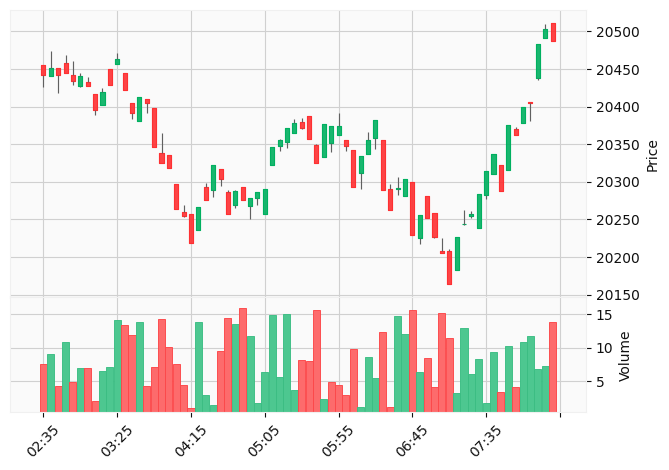

In [5]:
# Fitting BTCUSDT series on GBM

x0         = 23203.0 # initial price
series_len = 50000
timeframe  = 5

temp_df = df.iloc[-50000:]

n     = 1000 # group size
m     = 300  # overlap size

s     = [np.log(temp_df['Close'].iloc[i:i+n]) for i in range(0, len(temp_df), n-m)]
e     = np.array([all_estimates(si) for si in s])
avgs  = np.mean(e, axis=0)

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]

df_ = pd.DataFrame()
df_['price'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 70
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=True)

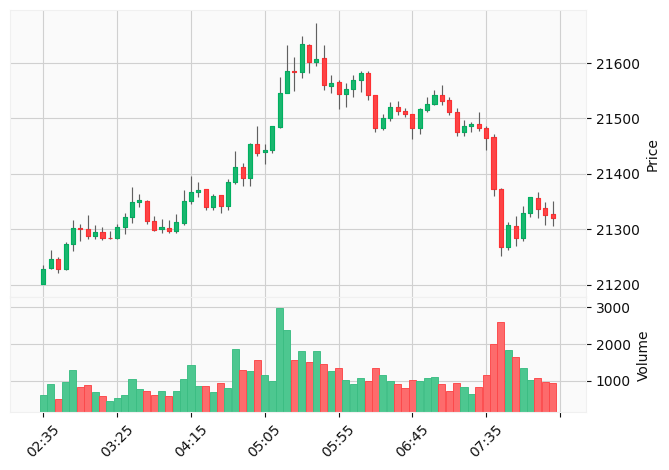

In [6]:
# Real BTCUSDT data resampled into 5minute OHLCV format

d = {
    'Open'  : 'first', 
    'High'  : 'max'  ,
    'Low'   : 'min'  ,
    'Close' : 'last' ,
    'Volume': 'sum'
    }
df_xm_orig = temp_df.resample(f"{timeframe}Min").agg(d)

plot_len = 70
mpf.plot(df_xm_orig.iloc[-plot_len:], type='candle', style='yahoo', volume=True)

In [7]:
# Synthetic prices 
df_xm

,Open,High,Low,Close,Volume
datetime,,,,,
2022-08-06 15:00:00,23225.770971,23225.770971,23225.770971,23225.770971,9.953724
2022-08-06 15:05:00,23225.051472,23256.175315,23214.359758,23256.175315,7.887333
2022-08-06 15:10:00,23238.062928,23255.710038,23222.454251,23255.710038,6.843342
2022-08-06 15:15:00,23245.816426,23245.816426,23206.845646,23206.845646,5.529957
2022-08-06 15:20:00,23172.065387,23188.120047,23160.011901,23162.981648,6.929691
...,...,...,...,...,...
2022-09-10 08:00:00,20378.170254,20398.844412,20378.170254,20398.844412,10.904607
2022-09-10 08:05:00,20406.150472,20406.150472,20381.226938,20404.227021,11.748762
2022-09-10 08:10:00,20438.412191,20483.637957,20435.420246,20483.637957,6.875961


In [8]:
# Real prices
df_xm_orig

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-08-06 15:00:00+00:00,23208.72,23209.81,23199.42,23203.33,79.89427
2022-08-06 15:05:00+00:00,23202.49,23215.67,23200.06,23213.65,185.40976
2022-08-06 15:10:00+00:00,23213.65,23229.70,23212.70,23219.08,245.73645
2022-08-06 15:15:00+00:00,23219.08,23221.00,23200.79,23207.47,193.31821
2022-08-06 15:20:00+00:00,23206.20,23216.22,23204.01,23207.98,127.35074
...,...,...,...,...,...
2022-09-10 08:00:00+00:00,21283.89,21341.37,21278.54,21329.83,1344.75618
2022-09-10 08:05:00+00:00,21329.03,21358.17,21321.26,21357.48,1018.13142
2022-09-10 08:10:00+00:00,21356.91,21366.77,21320.40,21336.17,1064.81850


In [9]:
# Dimension reduction

n_components = 2
seq_len      = 25
sample_size  = 2500
idxes        = np.random.permutation(len(df_xm))[:sample_size]
columns      = ['Open', 'High', 'Low', 'Close']

real_samples       = np.asarray(df_xm_orig[columns])[idxes]
synthetic_samples  = np.asarray(df_xm     [columns])[idxes]

synth_data_reduced = real_samples.reshape(-1, seq_len)
real_data_reduced  = np.asarray(synthetic_samples).reshape(-1,seq_len)

pca  = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

pca.fit(real_data_reduced)

pca_real     = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth    = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

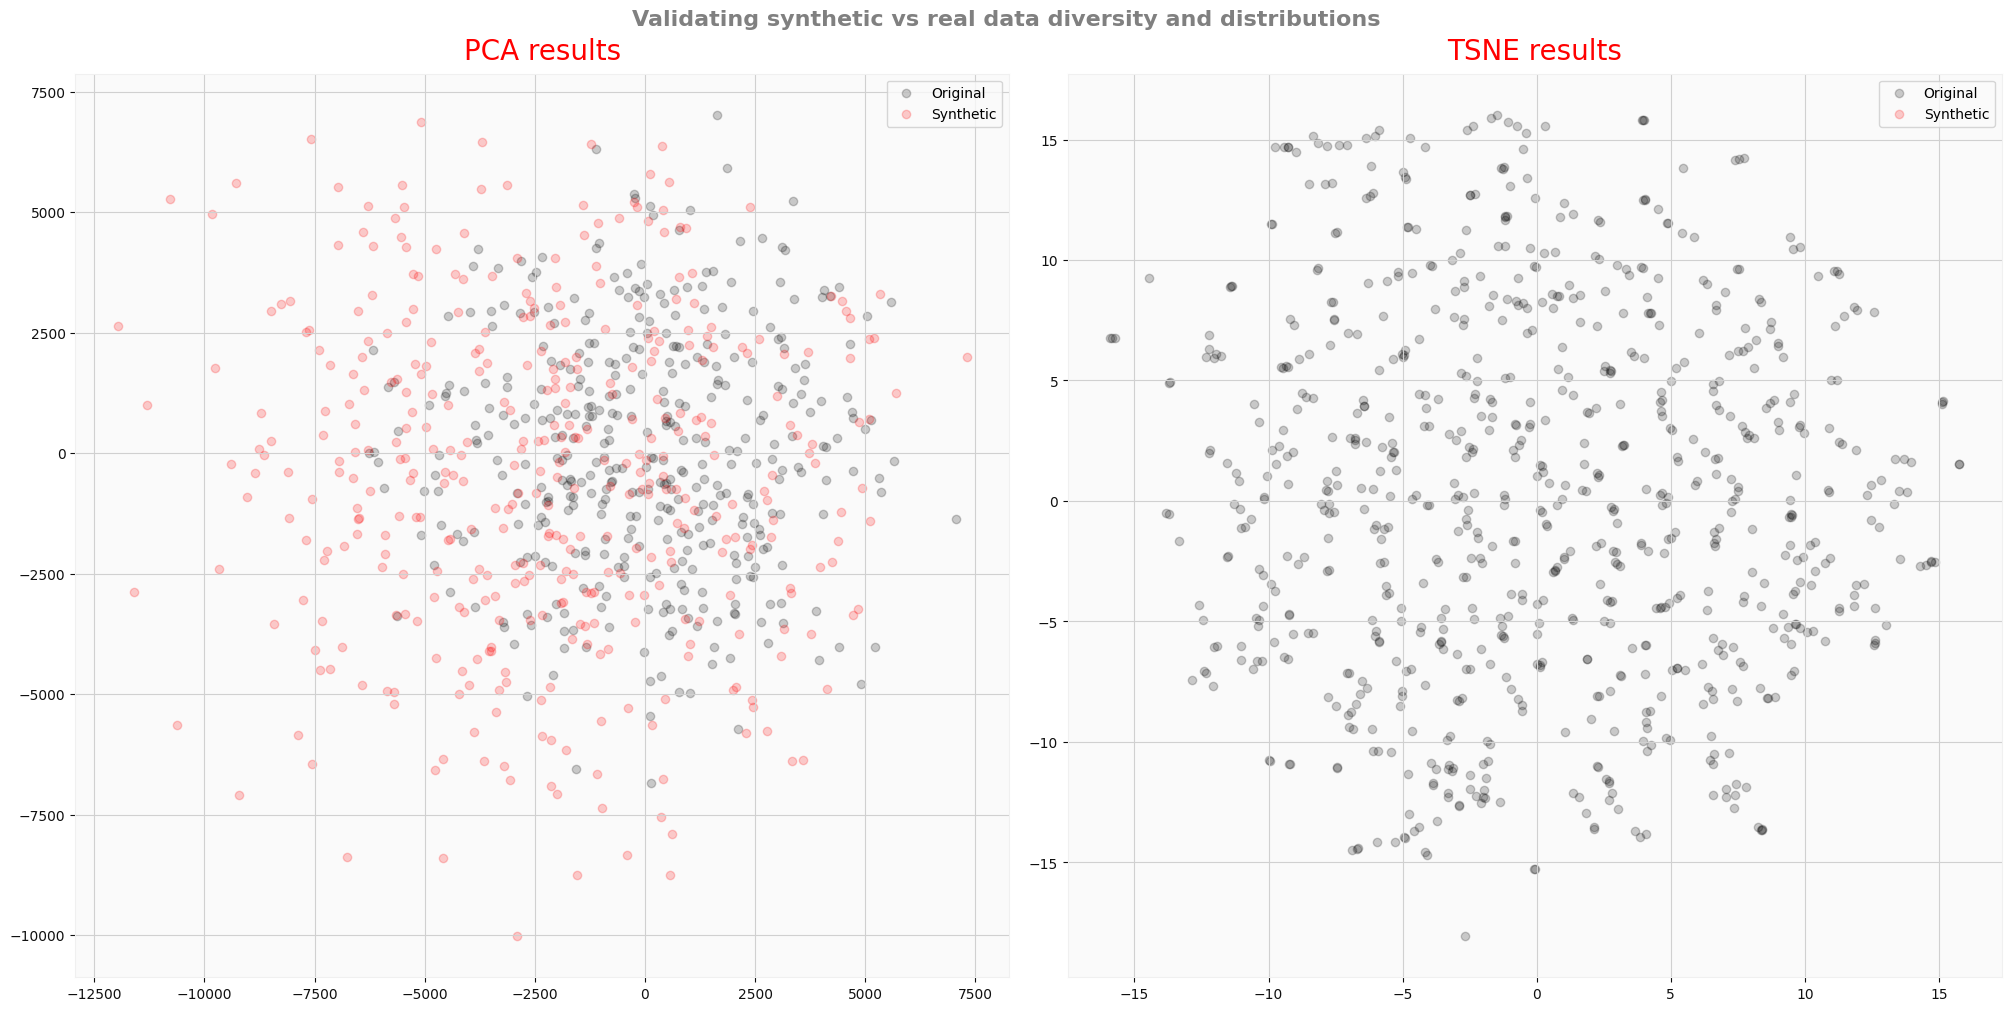

In [10]:
#The scatter plots for PCA and TSNE methods
fig  = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results', fontsize=20, color='red', pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values, c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1], c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results', fontsize=20, color='red', pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()
fig.suptitle('Validating synthetic vs real data diversity and distributions', fontsize=16, color='grey')